# Adversarial Search: Playing Connect 4

Student Name: Abdul Wasay

I have used the following AI tools: Github Copilot

I understand that my submission needs to be my own work: AW

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

##### Define the components of the search problem:

Initial state
 - Empty board (7 by 6) with no players having played
 
Actions
 - Valid places in the board where either player can place a disc given their turn. So a move is valid if its the lowest empty place in any column that doesnt have a disk already. 
 
Transition model (result function)
 - adding a disk to the correct position by the correct player and then letting other player make a valid move, until goal state. 
 
Goal state (terminal state and utility)
 - If you as the player gets your colored discs in a group of 4, vertically, horizontally or diagnally. (Win)
 - If the other player gets their colored discs in a group of 4, veritcally, horizontally or diagnally. (Loss)
 - If the board runs out of spaces for new discs to be placed and no players got 

##### How big is the state space? Give an estimate and explain it.

Maximum state space is estimated to be 3^42 because there are 3 valid possibilities (empty, player 1, player 2) for each of the squares (6*7=42)
 But this doesnt account for many illegal moves. 

One way to reduce it can be to calculate by taking the empty squares above another empty sqaure. This reduces it to 7.1*10^13 Allis (1988)

This should be further reducable by accounting for one player move after the other but cannot be reasonably estimated.

***Allis, V. (1988). A Knowledge-Based Approach of Connect-Four. J. Int. Comput. Games Assoc., 11, 165.*

##### How big is the game tree that minimax search will go through? Give an estimate and explain it.

If each cell is considered a new move and all moves are played (game doesnt end earlier), then the maximum depth would be 42 for the minmax tree. I.e. each move will create a new depth level to the tree until the game ends. 

Each player has a choice of 7 columns to choose from at the start of the game and that keeps reducing as the game progrsses. If we want to estimate a size of the tree, we would need to assume an average branching factor between 1 and 7 for the entire game. 

If we choose 4, then the size estimation would be 4^42 for the game tree . 

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [3]:
import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt


def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

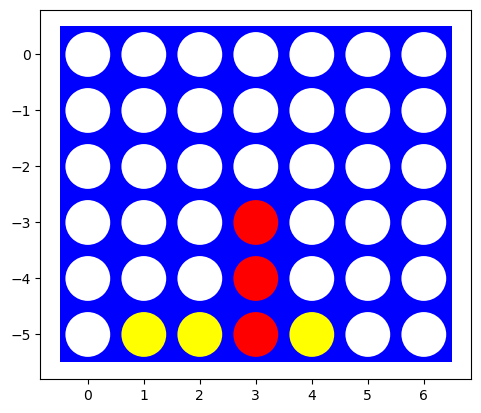

In [66]:
# Visualization code by Randolph Rankin
def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

#### actions: Tells you which columns are not full of discs hence are viable for discs by the player


#### result: Adds a disc to the right place on the board, noting that the board is reversed so that it places the disc in the right spot in the chosen column according to gravity. 


#### terminal: Checks if the board state is a terminal state, meaning either a player has won or all columns are full (draw).


#### utility: Tells the outcome for the game and returns 1 for a win for player 1, -1 for a loss for player 1, and 0 for a draw or ongoing game.


#### check_winner: Checks if a winning board is found i.e. 4 discs in a row either horizontally, vertically, or diagonally).

In [104]:
def actions(board):
    return [col for col in range(len(board[0])) if board[0][col] == 0]

def result(board, action, player):
    new_board = np.copy(board)
    for row in reversed(new_board):
        if row[action] == 0:
            row[action] = player
            break
    return new_board

def terminal(board):
    # Check for a win
    if check_winner(board, 1) or check_winner(board, -1):
        return True

    # Check for draw
    if all(board[0][col] != 0 for col in range(len(board[0]))):
        return True

    return False

def utility(board):
    # Check for player 1 win
    if check_winner(board, 1):
        return 1
    # Check for player -1 win
    elif check_winner(board, -1):
        return -1
    # No winner: draw or game still in progress
    else:
        return 0

def check_winner(board, player):
    rows, cols = board.shape

    # Check horizontal locations
    for row in range(rows):
        for col in range(cols - 3):
            if all(board[row][col + i] == player for i in range(4)):
                return True

    # Check vertical locations
    for row in range(rows - 3):
        for col in range(cols):
            if all(board[row + i][col] == player for i in range(4)):
                return True

    # Check positively sloped diagonals
    for row in range(rows - 3):
        for col in range(cols - 3):
            if all(board[row + i][col + i] == player for i in range(4)):
                return True

    # Check negatively sloped diagonals
    for row in range(3, rows):
        for col in range(cols - 3):
            if all(board[row - i][col + i] == player for i in range(4)):
                return True

    return False


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

Random Player Action: Column 5


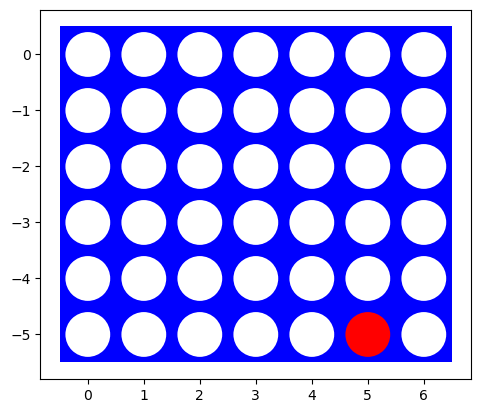

In [4]:
def random_player(board, player=1):
    # Get the list of available actions
    available_actions = actions(board)

    # Choose a random action from the available actions
    return random.choice(available_actions) if available_actions else None


board = empty_board()
player = 1

action = random_player(board, player)
print(f"Random Player Action: Column {action}")
new_b = result(board, action, player)
visualize(new_b)

### Random Placement working as intended

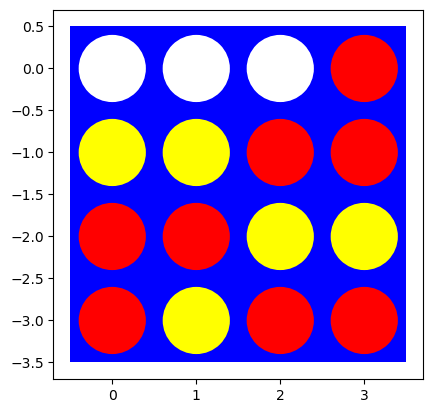

True

In [12]:
#diagnal win positive
board_test = np.array([
    [ 0,  0,  0,  1],
    [-1, -1,  1,  1],
    [ 1,  1, -1, -1],
    [ 1, -1,  1,  1]
])

visualize(board_test)
check_winner(board_test, 1)

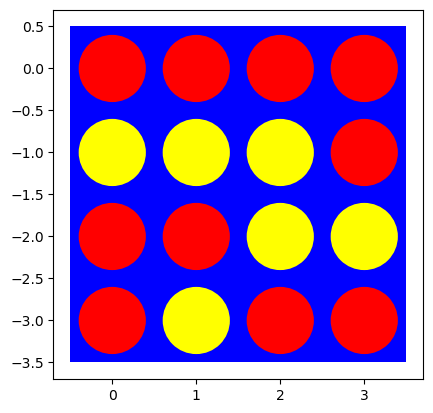

True

In [6]:
#horizontal win
board_test = np.array([
    [ 1,  1,  1,  1],
    [-1, -1, -1,  1],
    [ 1,  1, -1, -1],
    [ 1, -1,  1,  1]
])

visualize(board_test)
check_winner(board_test, 1)

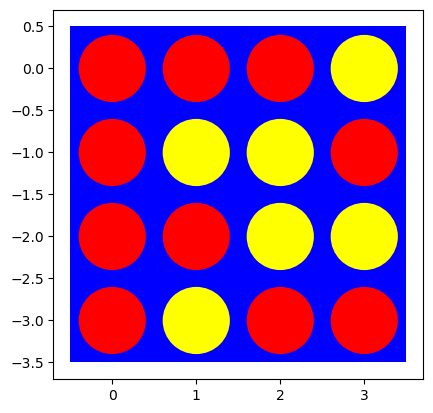

True

In [7]:
#vertical win
board_test = np.array([
    [1,  1,  1, -1],
    [1, -1, -1,  1],
    [1,  1, -1, -1],
    [1, -1,  1,  1]
])

visualize(board_test)
check_winner(board_test, 1)

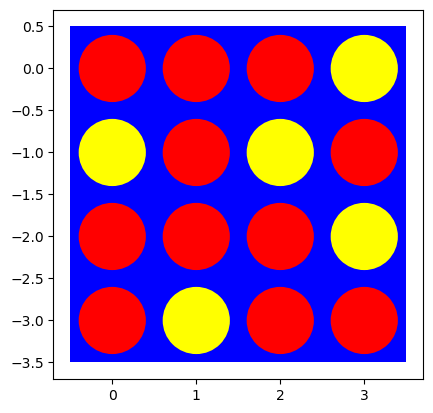

True

In [8]:
#diagnal win negative
board_test = np.array([
    [ 1,  1,  1, -1],
    [-1,  1, -1,  1],
    [ 1,  1,  1, -1],
    [ 1, -1,  1,  1]
])

visualize(board_test)
check_winner(board_test, 1)

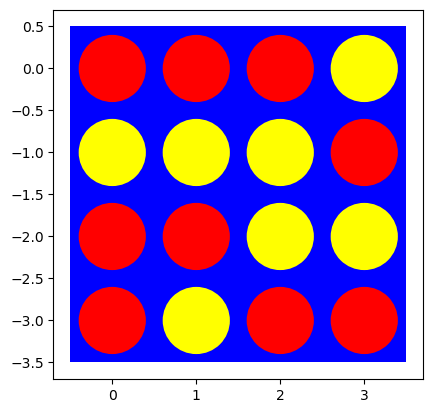

False

In [9]:
#no winner
board_test = np.array([
    [ 1,  1,  1, -1],
    [-1, -1, -1,  1],
    [ 1,  1, -1, -1],
    [ 1, -1,  1,  1]
])

visualize(board_test)
check_winner(board_test, 1)

### Win detection working as expected for both diagnals, not a winning board, horizaontal and vertical. 

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [5]:
def play_game(random_player_func):
    board = empty_board()
#     board = np.array([ #test board 
#     [ 0,  0,  0, 0],
#     [ 0,  0,  0, 0],
#     [ 0,  0,  0, 0],
#     [ 0,  0,  0, 0]
# ])
    player = 1  # Start with player 1
    while not terminal(board):
        action = random_player_func(board, player)
        board = result(board, action, player)
#         a= visualize(board) removed after testing if the game was played properly
        player *= -1  # Switch player
    return utility(board)

def simulate_games(num_games, random_player_func):
    results = {"Player 1 Wins": 0, "Player -1 Wins": 0, "Draws": 0}
    for _ in range(num_games):
        outcome = play_game(random_player_func)
        if outcome == 1:
            results["Player 1 Wins"] += 1
        elif outcome == -1:
            results["Player -1 Wins"] += 1
        else:
            results["Draws"] += 1
    return results

# simulation
num_games = 1000
results = simulate_games(num_games, random_player)

# Print results
print(f"After {num_games} games:")
for result, count in results.items():
    print(f"{result}: {count}")


player_1_win_rate = results["Player 1 Wins"] / num_games
player_minus_1_win_rate = results["Player -1 Wins"] / num_games
draw_rate = results["Draws"] / num_games
print(f"Player 1 Win Rate: {player_1_win_rate:.2%}")
print(f"Player -1 Win Rate: {player_minus_1_win_rate:.2%}")
print(f"Draw Rate: {draw_rate:.2%}")


After 1000 games:
Player 1 Wins: 546
Player -1 Wins: 450
Draws: 4
Player 1 Win Rate: 54.60%
Player -1 Win Rate: 45.00%
Draw Rate: 0.40%


### Draws are very hard to predict in this case (random) as it would mean that the whole board needs to be filled up  without any set of discs placed that would return a win for either agents. That means random woulf have to accuractely guess moves that dont let it or the other player win in order to get a draw. Hence although hard to predict, the number should be low.  

#### We have achieved a percentage draw rate of 0.4% over 1000 games which is in line with what was predicted. 

### Wins and Losses should be almost equal based on a random agent randomly deciding each placement. However, since the first placement carries a bit of an advantage and player 1 always plays first in the code above, we can account for minor advantage for player 1. 

#### And that is what is achieved, where 54.6% win and 45% loss percentages, are in line with what was predicted to happen. 

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [6]:
class Connect4Agent:
    def __init__(self, player=1):
        self.player = player
        self.COUNT = 0

    def actions(self, board):
        valid_actions = [col for col in range(len(board[0])) if board[0][col] == 0]
        if DEBUG >= 2:
            print(f"Valid actions: {valid_actions}")  # Debug print
        return valid_actions
    
    def result(self, board, action, player):
        new_board = np.copy(board)
        for row in reversed(new_board):
            if row[action] == 0:
                row[action] = player
                break
        return new_board

    def terminal(self, board):
        win_for_1 = self.check_winner(board, 1)
        win_for_minus_1 = self.check_winner(board, -1)
        full_board = all(board[0][col] != 0 for col in range(len(board[0])))
        if DEBUG >= 2:
            print(f"Win for 1: {win_for_1}, Win for -1: {win_for_minus_1}, Full board: {full_board}")
        return win_for_1 or win_for_minus_1 or full_board


    def utility(self, board, player):
        if self.check_winner(board, player):
            if DEBUG >= 2:
                print("Utility: Win detected")  # Debug print
            return float('inf')
        elif self.check_winner(board, -player):
            if DEBUG >= 2:
                print("Utility: Loss detected")  # Debug print
            return float('-inf')
        else:
            return 0
    def check_winner(self, board, player):
        rows, cols = board.shape

        # Check horizontal locations
        for row in range(rows):
            for col in range(cols - 3):
                if all(board[row][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Horizontal win detected at row {row}, starting at col {col} for player {player}")
                    return True

        # Check vertical locations
        for col in range(cols):
            for row in range(rows - 3):
                if all(board[row + i][col] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Vertical win detected at col {col}, starting at row {row} for player {player}")
                    return True

        # Check negatively sloped diagonals
        for row in range(rows - 3):
            for col in range(cols - 3):
                if all(board[row + i][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Negative diagonal win detected starting at row {row}, col {col} for player {player}")
                    return True

        # Check positively sloped diagonals
        for row in range(3, rows):
            for col in range(cols - 3):
                if all(board[row - i][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Positive diagonal win detected starting at row {row}, col {col} for player {player}")
                    return True

        return False

    def minimax_search(self, board):
        self.COUNT = 0
        value, move = self.max_value(board, self.player)
        if DEBUG >= 1: 
            print(f"Number of nodes searched: {self.COUNT}") 
        return {"move": move, "value": value}

    def max_value(self, state, player):
        self.COUNT += 1
        if DEBUG >= 2: 
            print(f"Max value called. Player: {player}, State: {state}")

        if self.terminal(state):
            return self.utility(state, player), None

        v, move = -math.inf, None
        for a in self.actions(state):
            v2, a2 = self.min_value(self.result(state, a, player), self.other(player))
            if DEBUG >= 2: 
                print(f"Max evaluating action {a}: score {v2}")
            if v2 == float('inf'):  # Immediate return on finding a winning move
                return v2, a
            if v2 > v:
                v, move = v2, a
        return v, move

    def min_value(self, state, player):
        self.COUNT += 1
        if DEBUG >= 2: 
            print(f"Min value called. Player: {player}, State: {state}")

        if self.terminal(state):
            return self.utility(state, self.other(player)), None

        v, move = math.inf, None
        for a in self.actions(state):
            v2, a2 = self.max_value(self.result(state, a, self.other(player)), player)
            if DEBUG >= 2: 
                print(f"Min evaluating action {a}: score {v2}")
            if v2 == float('-inf'):  # Immediate return on finding a losing move
                return v2, a
            if v2 < v:
                v, move = v2, a
        return v, move

    def other(self, player):
        return -player
        return v, move


In [7]:
DEBUG = 1
COUNT = 0
agent = Connect4Agent(player=1)

#best move is column 2
board_test = np.array([
    [ 0,  0,  0,  0],
    [-1, -1,  1,  1],
    [ 1,  1,  1, -1],
    [ 1, -1,  1,  1]
])

decision = agent.minimax_search(board_test)

print(f"Best move for Player 1: Column {decision['move']}")

#best move is column 3
board_test = np.array([
    [ 0,  0,  0,  0],
    [-1, -1,  1,  1],
    [ 1,  1, -1, -1],
    [ 1, -1,  1,  1]
])

decision = agent.minimax_search(board_test)

print(f"Best move for Player 1: Column {decision['move']}")

Number of nodes searched: 16
Best move for Player 1: Column 2
Number of nodes searched: 38
Best move for Player 1: Column 3


### The class is working as expected and predicting the right moves on smaller boards. 

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [22]:
# 1. Horizontal Win Test
# Player 1 needs to place a disc in column 7 (index 6) to win horizontally.
board_hor = np.array([
    [ 0,  0,  0,  0,  0,  0,  0],
    [-1, -1, -1,  1,  1,  1,  0],
    [ 1, -1,  1, -1,  1, -1,  1],
    [ 1, -1, -1,  1, -1, -1, -1],
    [-1,  1, -1,  1, -1,  1,  1],
    [ 1, -1,  1, -1, -1,  1, -1]
])

# 2. Vertical Win Test
# Player 1 needs to place a disc in column 3 (inex 2) to win vertically.
board_ver = np.array([
    [ 0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0],
    [-1,  1,  1, -1,  1,  1, -1],
    [ 1, -1,  1,  1, -1,  1, -1],
    [-1,  1,  1, -1, -1, -1,  1],
    [ 1, -1, -1,  1, -1, -1,  1]
])

# 3. Positive Diagonal Win Test
# Player 1 needs to place a disc in column 4 (index 3) for a positive diagonal win.
board_pd = np.array([
    [ 0,  1,  0,  0,  0,  0,  0],
    [-1, -1,  1,  0, -1,  1, -1],
    [ 1,  1,  1, -1,  1, -1,  1],
    [-1,  1, -1,  1,  1,  1, -1],
    [ 1,  1, -1,  1,  1,  1, -1]
])

# 4. Negative Diagonal Win Test
# Player 1 needs to place a disc in column 3(index 2) for a negative diagonal win.
board_nd = np.array([
    [ 0,  0,  0,  0,  0,  0,  0],
    [ 0,  1,  0,  0,  0,  0,  0],
    [-1, -1,  0,  0, -1,  1, -1],
    [ 1, -1,  1,  1,  1, -1,  1],
    [-1,  1,  1, -1,  1,  1, -1],
    [ 1, -1, -1,  1, -1,  1,  1]
])

# 5. Tie Scenario
# No moves left, resulting in a tie.
board_tie = np.array([
    [-1, -1, -1,  1, -1,  1,  0],
    [ 1, -1,  1, -1,  1, -1,  1],
    [-1, -1,  1,  1, -1, -1,  1],
    [ 1,  1, -1, -1,  1,  1, -1],
    [-1, -1,  1,  1, -1, -1,  1],
    [ 1,  1, -1, -1,  1, -1,  1]
])

DEBUG = 1
COUNT = 0

agent = Connect4Agent(player=1)
decision = agent.minimax_search(board_hor)

print(f"Best move for Player 1: Column {decision['move']}")

DEBUG = 1
COUNT = 0

decision = agent.minimax_search(board_ver)

print(f"Best move for Player 1: Column {decision['move']}")


DEBUG = 1
COUNT = 0

decision = agent.minimax_search(board_pd)

print(f"Best move for Player 1: Column {decision['move']}")

DEBUG = 1
COUNT = 0

decision = agent.minimax_search(board_nd)

print(f"Best move for Player 1: Column {decision['move']}")

DEBUG = 1
COUNT = 0

decision = agent.minimax_search(board_tie)

print(f"Best move for Player 1: Column {decision['move']}")

Number of nodes searched: 682
Best move for Player 1: Column 6
Number of nodes searched: 38
Best move for Player 1: Column 2
Number of nodes searched: 22
Best move for Player 1: Column 3
Number of nodes searched: 54
Best move for Player 1: Column 2
Number of nodes searched: 2
Best move for Player 1: Column 6


### As can be seen, the algorithm performs its intended purpose of finding the correct move for the 5 different scenarios (horizontal, vertical, +diagnal, -diagnal and tie. 

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [23]:
def measure_time(board, agent):
    start_time = time.time()
    COUNT=0
    agent.minimax_search(board)
    print(f"Best move for Player 1: Column {decision['move']}")
    end_time = time.time()
    return end_time - start_time

board_4col = np.array([
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 1, -1, -1,  0],
    [ 1, -1,  1,  1],
    [-1,  1, -1, -1],
    [ 1, -1,  1, -1]
])

board_5col = np.array([
    [ 0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0],
    [ 1,  0,  0,  1,  0],
    [-1,  1,  1, -1,  1],
    [ 1, -1, -1,  1, -1],
    [-1,  1,  1, -1,  1]
])


board_6col = np.array([
    [ 0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0],
    [-1,  1,  1, 1, -1,  0],
    [ 1, -1,  0,  1,  1,  1],
    [-1,  1,  1, -1, -1, -1],
    [ 1, -1,  1,  1, -1,  1]
])


board_7col = np.array([
    [ 0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0],
    [ 0,  1,  0,  0,  0, -1,  0],
    [ 1, -1,  1, -1,  1,  1, -1],
    [-1,  1, -1,  1, -1, -1,  1],
    [ 1, -1,  1, -1, -1,  1, -1]
])

In [34]:
column_sizes = [4, 5, 6, 7]
DEBUG=1
time_4col = measure_time(board_4col, agent)
time_5col = measure_time(board_5col, agent)
time_6col = measure_time(board_6col, agent)
time_7col = measure_time(board_7col, agent)


times_taken = [time_4col, time_5col, time_6col, time_7col]

Number of nodes searched: 1476
Best move for Player 1: Column 6
Number of nodes searched: 8726
Best move for Player 1: Column 6
Number of nodes searched: 16474
Best move for Player 1: Column 6
Number of nodes searched: 145150
Best move for Player 1: Column 6


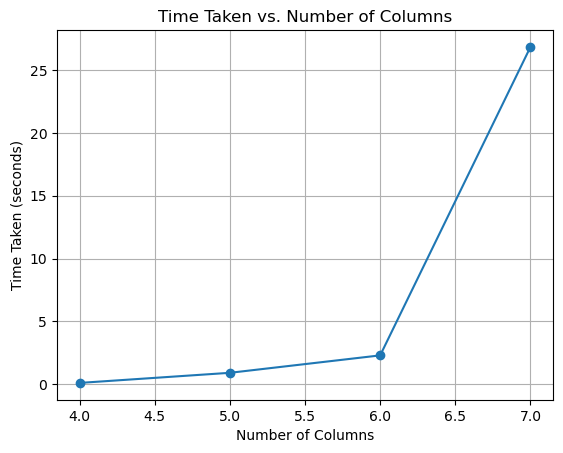

In [35]:
# Plotting
plt.plot(column_sizes, times_taken, marker='o')
plt.title('Time Taken vs. Number of Columns')
plt.xlabel('Number of Columns')
plt.ylabel('Time Taken (seconds)')
plt.grid(True)
plt.show()

### As can be seen, increasing the number of columns is increasing the time taken to solve the boards exponentially. This is expected as adding a new column increases the complexity of the search tree created. 

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

### Other than alpha beta pruning, the new class prioritizes immediate wins first and then preferring the middle columns to have a disc placed in them. This should decrease our times significantly

#### *minimax_search: is the main function for the minmax search algorithm that first checks for immediate winning moves, then explores other moves to find the best one. Basically plays the board for possible scanrios to find best possible outcome for the player. 

#### max_value: find best possible (maxmising utility) function for the player. 

#### min_value: find worst possible (minimizing utility) function for the opponent

In [25]:
class Connect4AgentAlphaBeta:
    def __init__(self, player=1):
        self.player = player
        self.COUNT = 0

    def actions(self, board):
        # Prioritize center columns
        cols = len(board[0])
        center_col = cols // 2
        ordered_actions = [center_col]

        for offset in range(1, center_col + 1):
            left = center_col - offset
            right = center_col + offset
            if left >= 0:
                ordered_actions.append(left)
            if right < cols:
                ordered_actions.append(right)

        return [col for col in ordered_actions if board[0][col] == 0]

    def result(self, board, action, player):
        new_board = np.copy(board)
        for row in reversed(new_board):
            if row[action] == 0:
                row[action] = player
                break
        return new_board

    def terminal(self, board):
        win_for_1 = self.check_winner(board, 1)
        win_for_minus_1 = self.check_winner(board, -1)
        full_board = all(board[0][col] != 0 for col in range(len(board[0])))
        if DEBUG >= 2:
            print(f"Win for 1: {win_for_1}, Win for -1: {win_for_minus_1}, Full board: {full_board}")
        return win_for_1 or win_for_minus_1 or full_board


    def utility(self, board, player):
        if self.check_winner(board, player):
            if DEBUG >= 2:
                print("Utility: Win detected")  # Debug print
            return float('inf')
        elif self.check_winner(board, -player):
            if DEBUG >= 2:
                print("Utility: Loss detected")  # Debug print
            return float('-inf')
        else:
            return 0
        
    def check_winner(self, board, player):
        rows, cols = board.shape

        # Check horizontal locations
        for row in range(rows):
            for col in range(cols - 3):
                if all(board[row][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Horizontal win detected at row {row}, starting at col {col} for player {player}")
                    return True

        # Check vertical locations
        for col in range(cols):
            for row in range(rows - 3):
                if all(board[row + i][col] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Vertical win detected at col {col}, starting at row {row} for player {player}")
                    return True

        # Check negatively sloped diagonals
        for row in range(rows - 3):
            for col in range(cols - 3):
                if all(board[row + i][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Negative diagonal win detected starting at row {row}, col {col} for player {player}")
                    return True

        # Check positively sloped diagonals
        for row in range(3, rows):
            for col in range(cols - 3):
                if all(board[row - i][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Positive diagonal win detected starting at row {row}, col {col} for player {player}")
                    return True

        return False

    def minimax_search(self, board):
        self.COUNT = 0

        # First, check for any immediate winning move
        for col in range(len(board[0])):
            if board[0][col] == 0:
                temp_board = self.result(np.copy(board), col, self.player)
                if self.check_winner(temp_board, self.player): 
                    print(f"Number of nodes searched: {self.COUNT}")
                    return {"move": col, "value": float('inf')}

        # If no immediate winning move, proceed with alpha-beta pruning
        alpha = -math.inf
        beta = math.inf
        value, move = self.max_value(board, alpha, beta, self.player)
        if DEBUG >= 1: 
            print(f"Number of nodes searched: {self.COUNT}")
        return {"move": move, "value": value}


    def max_value(self, state, alpha, beta, player):
        self.COUNT += 1
        if self.terminal(state):
            return self.utility(state, player), None

        v, move = -math.inf, None
        for a in self.actions(state):
            v2, a2 = self.min_value(self.result(state, a, player), alpha, beta, -player)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                break  # Beta cutoff
        return v, move

    def min_value(self, state, alpha, beta, player):
        self.COUNT += 1
        if self.terminal(state):
            return self.utility(state, -player), None

        v, move = math.inf, None
        for a in self.actions(state):
            v2, a2 = self.max_value(self.result(state, a, -player), alpha, beta, player)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                break  # Alpha cutoff
        return v, move

In [15]:
agent2 = Connect4AgentAlphaBeta(player=1)

DEBUG = 1

#best move is column 2
board_test = np.array([
    [ 0,  0,  0,  0],
    [-1, -1,  1,  1],
    [ 1,  1,  1, -1],
    [ 1, -1,  1,  1]
])

decision = agent2.minimax_search(board_test)

print(f"Best move for Player 1: Column {decision['move']}")

#best move is column 3
board_test = np.array([
    [ 0,  0,  0,  0],
    [-1, -1,  1,  1],
    [ 1,  1, -1, -1],
    [ 1, -1,  1,  1]
])

decision = agent2.minimax_search(board_test)

print(f"Best move for Player 1: Column {decision['move']}")

#best move is column 2
board_test = np.array([
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 1,  1, -1, -1],
    [ 1, -1,  1,  1]
])

decision = agent2.minimax_search(board_test)

print(f"Best move for Player 1: Column {decision['move']}")

Number of nodes searched: 0
Best move for Player 1: Column 2
Number of nodes searched: 0
Best move for Player 1: Column 3
Number of nodes searched: 673
Best move for Player 1: Column 2


In [26]:

agent2 = Connect4AgentAlphaBeta(player=1)
def measure_time_2(board, agent):
    start_time = time.time()
    COUNT=0
    agent2.minimax_search(board)
    print(f"Best move for Player 1: Column {decision['move']}")
    end_time = time.time()
    return end_time - start_time

In [37]:
column_sizes = [4, 5, 6, 7]
DEBUG=1
time_4col2 = measure_time_2(board_4col, agent2)
time_5col2 = measure_time_2(board_5col, agent2)
time_6col2 = measure_time_2(board_6col, agent2)
time_7col2 = measure_time_2(board_7col, agent2)

times_taken_2 = [time_4col2, time_5col2, time_6col2, time_7col2]

Number of nodes searched: 0
Best move for Player 1: Column 6
Number of nodes searched: 0
Best move for Player 1: Column 6
Number of nodes searched: 0
Best move for Player 1: Column 6
Number of nodes searched: 0
Best move for Player 1: Column 6


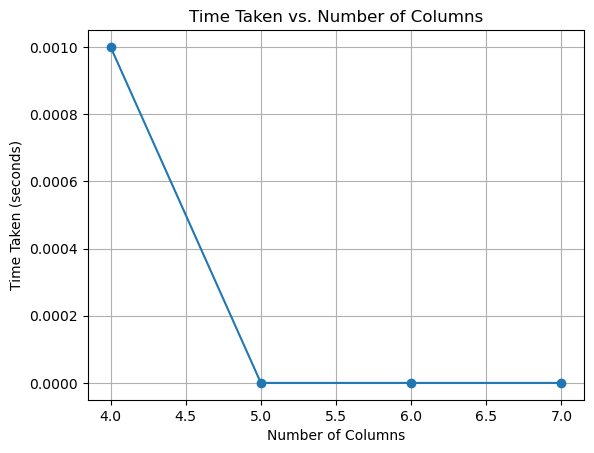

In [38]:
# Plotting
plt.plot(column_sizes, times_taken_2, marker='o')
plt.title('Time Taken vs. Number of Columns')
plt.xlabel('Number of Columns')
plt.ylabel('Time Taken (seconds)')
plt.grid(True)
plt.show()

In [39]:
# Printing the table header
print(f"{'Board Size':<12} | {'Time Agent 1 (s)':<16} | {'Time Agent 2 (s)':<16}")
print("-" * 45)

# Printing each row of the table
for size, time1, time2 in zip(column_sizes, times_taken, times_taken_2):
    print(f"{size:<12} | {time1:<16.4f} | {time2:<16.4f}")

Board Size   | Time Agent 1 (s) | Time Agent 2 (s)
---------------------------------------------
4            | 0.1105           | 0.0010          
5            | 0.9154           | 0.0000          
6            | 2.3020           | 0.0000          
7            | 26.8438          | 0.0000          


### as can be seen the new techniques of selcting the immediate winning  moves have significantly reduced the processing time. When it finds the winning move immediately, it actually reduces time to less than 0.000

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [11]:
def empty_board(row, col):
    return np.full((row, col), fill_value=0)

empty_4 = empty_board(4,4)

time_4col3 = measure_time_2(empty_4, agent2)

Number of nodes searched: 287492
Best move for Player 1: Column 3


In [12]:
print(time_4col3)

9.596614360809326


### As can be seen above, the time taken has increased significantly, to 10 seconds and random would almost be instant and will increase significantly everytime a new column is added.  

### what we can do is cap the max number of nodes that can be searched, or even detect if board is empty, and then just play a middle column to start.  

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [22]:
def random_player(board, player):
    valid_actions = [col for col in range(len(board[0])) if board[0][col] == 0]
    return random.choice(valid_actions) if valid_actions else None

# function to play the game and show the board after each move
def play_game_show_board(agent, initial_board):
    board = np.copy(initial_board)
    player = 1  # Start with player 1 (agent)

    while not agent.terminal(board):
        if player == 1:
            action = agent.minimax_search(board)['move']  # Agent's move
        else:
            action = random_player(board, player)  # Random player's move

        if action is not None:
            board = agent.result(board, action, player)
            print (action, player)
#             visualize(board)  # Show board after  move

        player *= -1  # Switch player

    # Return the final utility value (win, lose, draw)
    return agent.utility(board, agent.player)

DEBUG=1
agent = Connect4AgentAlphaBeta(player=1)
board_test = np.array([
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0]
])

final_utility = play_game_show_board(agent, board_test)
print("Final Utility:", final_utility)


Number of nodes searched: 287492
1 -1
Number of nodes searched: 20451
2 1
2 -1
Number of nodes searched: 3838
2 1
3 -1
Number of nodes searched: 1528
2 1
0 -1
Number of nodes searched: 326
1 1
3 -1
Number of nodes searched: 114
1 1
0 -1
Number of nodes searched: 30
1 1
0 -1
Number of nodes searched: 9
3 1
0 -1
Final Utility: -inf


In [25]:
DEBUG=0
def empty_board(row, col):
    return np.full((row, col), fill_value=0)

def random_player(board, player):
    valid_actions = [col for col in range(len(board[0])) if board[0][col] == 0]

    if valid_actions:
        return random.choice(valid_actions)
    else:
        return None 

def play_game(agent, random_player_func):
    board = empty_board(4,4)
    player = 1  # Start with player 1
    while not terminal(board):
        if player == 1:
            action = agent.minimax_search(board)['move']  
        else:
            action = random_player_func(board, player)  

        if action is None:  # No valid moves available
            break

        board = result(board, action, player)
        player *= -1  # Switch player

    return utility(board)

def simulate_games(num_games, agent, random_player_func):
    results = {"Player 1 Wins": 0, "Player -1 Wins": 0, "Draws": 0}
    for _ in range(num_games):
        outcome = play_game(agent, random_player_func)
        if outcome == 1:
            results["Player 1 Wins"] += 1
        elif outcome == -1:
            results["Player -1 Wins"] += 1
        else:
            results["Draws"] += 1
    return results


alpha_beta_agent = Connect4AgentAlphaBeta(player=1)
DEBUG=1
num_games = 100
results = simulate_games(num_games, alpha_beta_agent, random_player)

print(f"After {num_games} games:")
for result, count in results.items():
    print(f"{result}: {count}")

player_1_win_rate = results["Player 1 Wins"] / num_games
player_minus_1_win_rate = results["Player -1 Wins"] / num_games
draw_rate = results["Draws"] / num_games
print(f"Player 1 Win Rate: {player_1_win_rate:.2%}")
print(f"Player -1 Win Rate: {player_minus_1_win_rate:.2%}")
print(f"Draw Rate: {draw_rate:.2%}")


Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of nodes searched: 287492
Number of 

### since the min max is not actually calculating through a hueristic, it actually plays as good as random in this instance. It doesnt know to add utility to unfinished boards, its only calculating for winning moves, and when a board is empty, its not performing as needed. Combine that with a board that is only 4x4, its leads to perfect draws with random. We can fix that by adding a Heuristic. 

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [8]:
class Connect4AgentAlphaBeta_H:
    def __init__(self, player=1):
        self.player = player
        self.COUNT = 0

    def actions(self, board):
        # Prioritize center columns
        cols = len(board[0])
        center_col = cols // 2
        ordered_actions = [center_col]

        for offset in range(1, center_col + 1):
            left = center_col - offset
            right = center_col + offset
            if left >= 0:
                ordered_actions.append(left)
            if right < cols:
                ordered_actions.append(right)

        return [col for col in ordered_actions if board[0][col] == 0]

    def result(self, board, action, player):
        new_board = np.copy(board)
        for row in reversed(new_board):
            if row[action] == 0:
                row[action] = player
                break
        return new_board

    def terminal(self, board):
        win_for_1 = self.check_winner(board, 1)
        win_for_minus_1 = self.check_winner(board, -1)
        full_board = all(board[0][col] != 0 for col in range(len(board[0])))
        if DEBUG >= 2:
            print(f"Win for 1: {win_for_1}, Win for -1: {win_for_minus_1}, Full board: {full_board}")
        return win_for_1 or win_for_minus_1 or full_board


    def utility(self, board, player):
            if self.check_winner(board, player):
                return float('inf')  # Win
            elif self.check_winner(board, -player):
                return float('-inf')  # Loss
            else:
                return self.evaluate_board(board, player)

    def check_winner(self, board, player):
        rows, cols = board.shape

        # Check horizontal locations
        for row in range(rows):
            for col in range(cols - 3):
                if all(board[row][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Horizontal win detected at row {row}, starting at col {col} for player {player}")
                    return True

        # Check vertical locations
        for col in range(cols):
            for row in range(rows - 3):
                if all(board[row + i][col] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Vertical win detected at col {col}, starting at row {row} for player {player}")
                    return True

        # Check negatively sloped diagonals
        for row in range(rows - 3):
            for col in range(cols - 3):
                if all(board[row + i][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Negative diagonal win detected starting at row {row}, col {col} for player {player}")
                    return True

        # Check positively sloped diagonals
        for row in range(3, rows):
            for col in range(cols - 3):
                if all(board[row - i][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Positive diagonal win detected starting at row {row}, col {col} for player {player}")
                    return True

        return False
    
    def evaluate_board(self, board, player):
        score = 0

        # Define scoring criteria
        def score_sequence(sequence, player):
            count_player = np.sum(sequence == player)
            count_empty = np.sum(sequence == 0)

            if count_player == 3 and count_empty == 1:
                return 100  # Three in a row with an open end
            elif count_player == 2 and count_empty == 2:
                return 10  # Two in a row with open ends
            return 0

        rows, cols = board.shape

        # Evaluate all possible sequences
        for row in range(rows):
            for col in range(cols - 3):
                # Horizontal
                horizontal_seq = board[row][col:col + 4]
                score += score_sequence(horizontal_seq, player)

                # Vertical (only if enough rows below)
                if row <= rows - 4:
                    vertical_seq = [board[r][col] for r in range(row, row + 4)]
                    score += score_sequence(vertical_seq, player)

                # Positively sloped diagonals
                if row <= rows - 4:
                    pos_diag_seq = [board[row + i][col + i] for i in range(4)]
                    score += score_sequence(pos_diag_seq, player)

                # Negatively sloped diagonals
                if row >= 3:
                    neg_diag_seq = [board[row - i][col + i] for i in range(4)]
                    score += score_sequence(neg_diag_seq, player)

        # Control of the center column
        center_col = cols // 2
        center_count = sum([1 for r in range(rows) if board[r][center_col] == player])
        score += center_count * 3

        return score

    def minimax_search(self, board):
        self.COUNT = 0

        # First, check for any immediate winning move
        for col in range(len(board[0])):
            if board[0][col] == 0:
                temp_board = self.result(np.copy(board), col, self.player)
                if self.check_winner(temp_board, self.player): 
                    print(f"Number of nodes searched: {self.COUNT}")
                    return {"move": col, "value": float('inf')}

        # If no immediate winning move, proceed with alpha-beta pruning
        alpha = -math.inf
        beta = math.inf
        value, move = self.max_value(board, alpha, beta, self.player)
        if DEBUG >= 1: 
            print(f"Number of nodes searched: {self.COUNT}")
        return {"move": move, "value": value}


    def max_value(self, state, alpha, beta, player):
        if self.terminal(state):
            return self.utility(state, player), None

        v, move = -math.inf, None
        for a in self.actions(state):
            v2, _ = self.min_value(self.result(state, a, player), alpha, beta, -player)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if alpha >= beta:
                break  # Beta cutoff
        return v, move

    def min_value(self, state, alpha, beta, player):
        if self.terminal(state):
            return self.utility(state, -player), None

        v, move = math.inf, None
        for a in self.actions(state):
            v2, _ = self.max_value(self.result(state, a, -player), alpha, beta, player)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if alpha >= beta:
                break  # Alpha cutoff
        return v, move
            # Alpha cutoff
        return v, move

In [9]:
H_agent = Connect4AgentAlphaBeta_H(player=1)
DEBUG=1

board_test = np.array([
    [ 0,  0,  0,  0],
    [-1, -1,  1,  1],
    [ 1,  1,  1, -1],
    [ 1, -1,  1,  1]
])

decision = H_agent.minimax_search(board_test)

print(f"Best move for Player 1: Column {decision['move']}")

#best move is column 3
board_test = np.array([
    [ 0,  0,  0,  0],
    [-1, -1,  1,  1],
    [ 1,  1, -1, -1],
    [ 1, -1,  1,  1]
])

decision = H_agent.minimax_search(board_test)

print(f"Best move for Player 1: Column {decision['move']}")

#best move is column 2
board_test = np.array([
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 1,  1, -1, -1],
    [ 1, -1,  1,  1]
])

decision = H_agent.minimax_search(board_test)

print(f"Best move for Player 1: Column {decision['move']}")

Number of nodes searched: 0
Best move for Player 1: Column 2
Number of nodes searched: 0
Best move for Player 1: Column 3
Number of nodes searched: 0
Best move for Player 1: Column 2


Number of nodes searched: 0
2 1


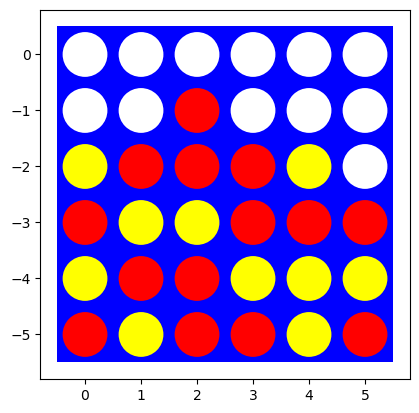

4 -1


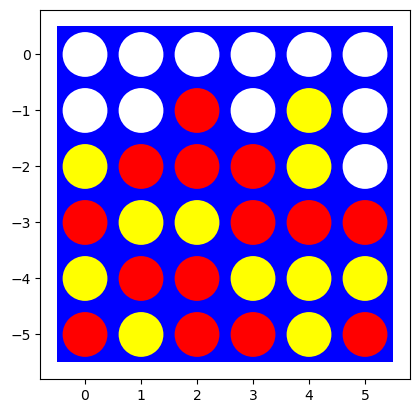

Number of nodes searched: 0
2 1


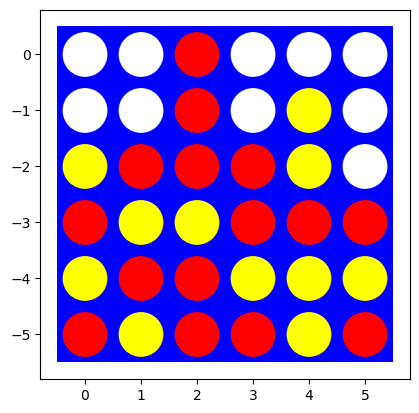

4 -1


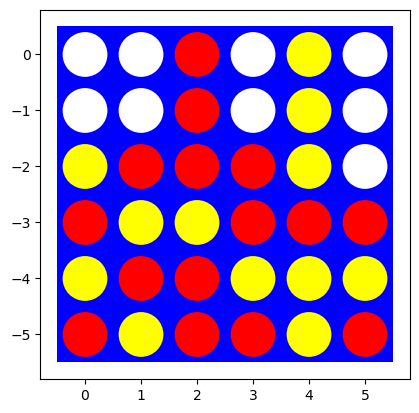

Number of nodes searched: 0
5 1


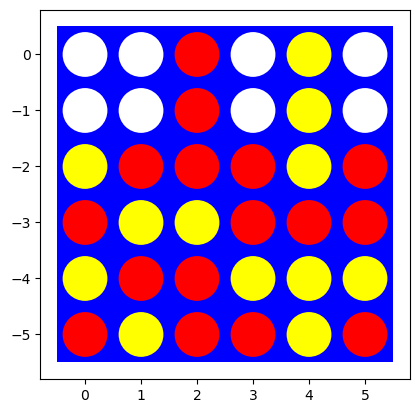

0 -1


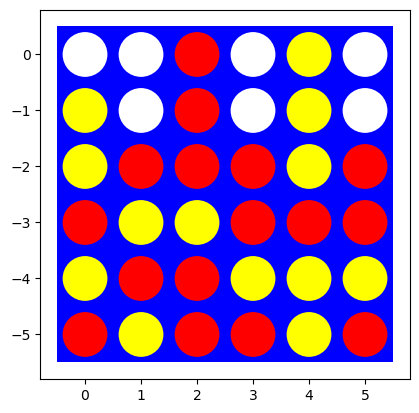

Number of nodes searched: 0
5 -1


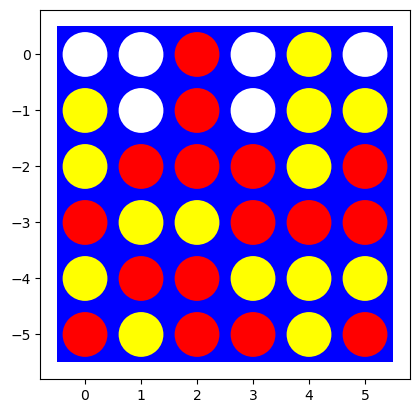

Number of nodes searched: 0
5 1


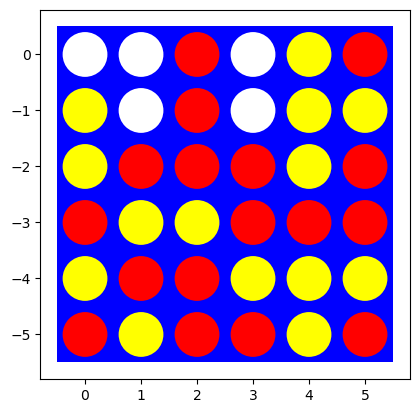

3 -1


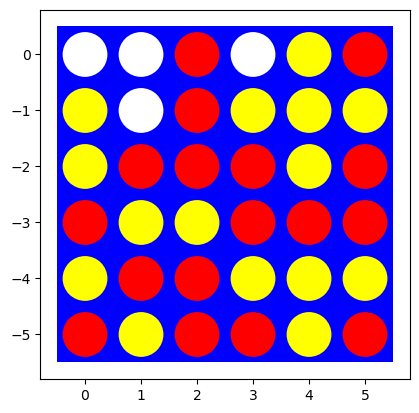

Number of nodes searched: 0
3 1


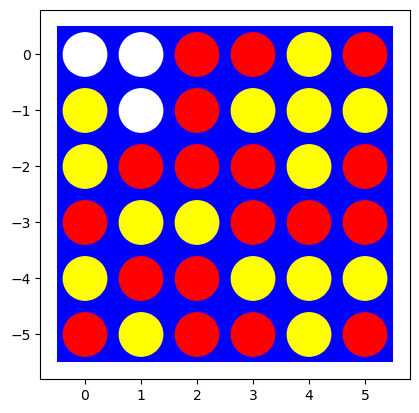

Final Utility: inf


In [13]:
H_agent = Connect4AgentAlphaBeta_H(player=1)
DEBUG=1

def random_player(board, player):
    valid_actions = [col for col in range(len(board[0])) if board[0][col] == 0]
    return random.choice(valid_actions) if valid_actions else None

# function to play the game and show the board after each move
def play_game_show_board(agent, initial_board):
    board = np.copy(initial_board)
    player = 1  # Start with player 1 (agent)

    while not agent.terminal(board):
        if player == 1:
            action = agent.minimax_search(board)['move']  # Agent's move
        else:
            action = random_player(board, player)  # Random player's move

        if action is not None:
            board = agent.result(board, action, player)
            print (action, player)
            visualize(board)  # Show board after  move

        player *= -1  # Switch player

    # Return the final utility value (win, lose, draw)
    return agent.utility(board, agent.player)


board_test = np.array([
    [ 0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0],
    [-1,  1,  1, 1, -1,  0],
    [ 1, -1,  -1,  1,  1,  1],
    [-1,  1,  1, -1, -1, -1],
    [ 1, -1,  1,  1, -1,  1]
])

final_utility = play_game_show_board(H_agent, board_test)
print("Final Utility:", final_utility)

### Cutting off search [10 points]

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [17]:
class depth_limit:
    def __init__(self, player=1, depth_limit=4):
        self.player = player
        self.COUNT = 0
        self.depth_limit = depth_limit
        
    def actions(self, board):
        # Prioritize center columns
        cols = len(board[0])
        center_col = cols // 2
        ordered_actions = [center_col]

        for offset in range(1, center_col + 1):
            left = center_col - offset
            right = center_col + offset
            if left >= 0:
                ordered_actions.append(left)
            if right < cols:
                ordered_actions.append(right)

        return [col for col in ordered_actions if board[0][col] == 0]

    def result(self, board, action, player):
        new_board = np.copy(board)
        for row in reversed(new_board):
            if row[action] == 0:
                row[action] = player
                break
        return new_board

    def terminal(self, board):
        win_for_1 = self.check_winner(board, 1)
        win_for_minus_1 = self.check_winner(board, -1)
        full_board = all(board[0][col] != 0 for col in range(len(board[0])))
        if DEBUG >= 2:
            print(f"Win for 1: {win_for_1}, Win for -1: {win_for_minus_1}, Full board: {full_board}")
        return win_for_1 or win_for_minus_1 or full_board


    def utility(self, board, player):
            if self.check_winner(board, player):
                return float('inf')  # Win
            elif self.check_winner(board, -player):
                return float('-inf')  # Loss
            else:
                return self.evaluate_board(board, player)

    def check_winner(self, board, player):
        rows, cols = board.shape

        # Check horizontal locations
        for row in range(rows):
            for col in range(cols - 3):
                if all(board[row][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Horizontal win detected at row {row}, starting at col {col} for player {player}")
                    return True

        # Check vertical locations
        for col in range(cols):
            for row in range(rows - 3):
                if all(board[row + i][col] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Vertical win detected at col {col}, starting at row {row} for player {player}")
                    return True

        # Check negatively sloped diagonals
        for row in range(rows - 3):
            for col in range(cols - 3):
                if all(board[row + i][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Negative diagonal win detected starting at row {row}, col {col} for player {player}")
                    return True

        # Check positively sloped diagonals
        for row in range(3, rows):
            for col in range(cols - 3):
                if all(board[row - i][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Positive diagonal win detected starting at row {row}, col {col} for player {player}")
                    return True

        return False
    
    def evaluate_board(self, board, player):
        score = 0

        # Define scoring criteria
        def score_sequence(sequence, player):
            count_player = np.sum(sequence == player)
            count_empty = np.sum(sequence == 0)

            if count_player == 3 and count_empty == 1:
                return 100  # Three in a row with an open end
            elif count_player == 2 and count_empty == 2:
                return 10  # Two in a row with open ends
            return 0

        rows, cols = board.shape

        # Evaluate all possible sequences
        for row in range(rows):
            for col in range(cols - 3):
                # Horizontal
                horizontal_seq = board[row][col:col + 4]
                score += score_sequence(horizontal_seq, player)

                # Vertical (only if enough rows below)
                if row <= rows - 4:
                    vertical_seq = [board[r][col] for r in range(row, row + 4)]
                    score += score_sequence(vertical_seq, player)

                # Positively sloped diagonals
                if row <= rows - 4:
                    pos_diag_seq = [board[row + i][col + i] for i in range(4)]
                    score += score_sequence(pos_diag_seq, player)

                # Negatively sloped diagonals
                if row >= 3:
                    neg_diag_seq = [board[row - i][col + i] for i in range(4)]
                    score += score_sequence(neg_diag_seq, player)

        # Control of the center column
        center_col = cols // 2
        center_count = sum([1 for r in range(rows) if board[r][center_col] == player])
        score += center_count * 3

        return score

    def minimax_search(self, board, depth=0):
        self.COUNT = 0
        alpha = -math.inf
        beta = math.inf
        value, move = self.max_value(board, alpha, beta, self.player, depth)
        if DEBUG >= 1: 
            print(f"Number of nodes searched: {self.COUNT}")
        return {"move": move, "value": value}

    def max_value(self, state, alpha, beta, player, depth):
        self.COUNT += 1
        if depth == self.depth_limit or self.terminal(state):
            return self.utility(state, player), None

        v, move = -math.inf, None
        for a in self.actions(state):
            v2, _ = self.min_value(self.result(state, a, player), alpha, beta, -player, depth + 1)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if alpha >= beta:
                break  # Beta cutoff
        return v, move

    def min_value(self, state, alpha, beta, player, depth):
        self.COUNT += 1
        if depth == self.depth_limit or self.terminal(state):
            return self.utility(state, -player), None

        v, move = math.inf, None
        for a in self.actions(state):
            v2, _ = self.max_value(self.result(state, a, -player), alpha, beta, player, depth + 1)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if alpha >= beta:
                break  # Alpha cutoff
        return v, move

In [18]:
deep_3 = depth_limit(player=1, depth_limit=3)
deep_5 = depth_limit(player=1, depth_limit=5)


board_test = np.array([
    [ 0,  0,  0,  0],
    [-1, -1,  1,  1],
    [ 1,  1,  1, -1],
    [ 1, -1,  1,  1]
])

decision1 = deep_3.minimax_search(board_test)
print(f"Best move for Player 1: Column {decision1['move']}")
decision2 = deep_5.minimax_search(board_test)
print(f"Best move for Player 1: Column {decision2['move']}")

#best move is column 3
board_test = np.array([
    [ 0,  0,  0,  0],
    [-1, -1,  1,  1],
    [ 1,  1, -1, -1],
    [ 1, -1,  1,  1]
])

decision1 = deep_3.minimax_search(board_test)
print(f"Best move for Player 1: Column {decision1['move']}")
decision2 = deep_5.minimax_search(board_test)
print(f"Best move for Player 1: Column {decision2['move']}")

#best move is column 2
board_test = np.array([
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 1,  1, -1, -1],
    [ 1, -1,  1,  1]
])

decision1 = deep_3.minimax_search(board_test)
print(f"Best move for Player 1: Column {decision1['move']}")
decision2 = deep_5.minimax_search(board_test)
print(f"Best move for Player 1: Column {decision2['move']}")

Number of nodes searched: 2
Best move for Player 1: Column 2
Number of nodes searched: 2
Best move for Player 1: Column 2
Number of nodes searched: 12
Best move for Player 1: Column 3
Number of nodes searched: 16
Best move for Player 1: Column 3
Number of nodes searched: 36
Best move for Player 1: Column 1
Number of nodes searched: 318
Best move for Player 1: Column 2


Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [21]:
# 1. Horizontal Win Test
# Player 1 needs to place a disc in column 7 (index 6) to win horizontally.
board_hor = np.array([
    [ 0,  0,  0,  0,  0,  0,  0],
    [-1, -1, -1,  1,  1,  1,  0],
    [ 1, -1,  1, -1,  1, -1,  1],
    [ 1, -1, -1,  1, -1, -1, -1],
    [-1,  1, -1,  1, -1,  1,  1],
    [ 1, -1,  1, -1, -1,  1, -1]
])

# 2. Vertical Win Test
# Player 1 needs to place a disc in column 3 (index 2) to win vertically.
board_ver = np.array([
    [ 0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0],
    [-1,  1,  1, -1,  1,  1, -1],
    [ 1, -1,  1,  1, -1,  1, -1],
    [-1,  1,  1, -1, -1, -1,  1],
    [ 1, -1, -1,  1, -1, -1,  1]
])

# 3. Positive Diagonal Win Test
# Player 1 needs to place a disc in column 4 (index 3) for a positive diagonal win.
board_pd = np.array([
    [ 0,  1,  0,  0,  0,  0,  0],
    [-1, -1,  1,  0, -1,  1, -1],
    [ 1,  1,  1, -1,  1, -1,  1],
    [-1,  1, -1,  1,  1,  1, -1],
    [ 1,  1, -1,  1,  1,  1, -1]
])

# 4. Negative Diagonal Win Test
# Player 1 needs to place a disc in column 3(index 2) for a negative diagonal win.
board_nd = np.array([
    [ 0,  0,  0,  0,  0,  0,  0],
    [ 0,  1,  0,  0,  0,  0,  0],
    [-1, -1,  0,  0, -1,  1, -1],
    [ 1, -1,  1,  1,  1, -1,  1],
    [-1,  1,  1, -1,  1,  1, -1],
    [ 1, -1, -1,  1, -1,  1,  1]
])

# 5. Tie Scenario
# No moves left, resulting in a tie.
board_tie = np.array([
    [-1, -1, -1,  1, -1,  1,  0],
    [ 1, -1,  1, -1,  1, -1,  1],
    [-1, -1,  1,  1, -1, -1,  1],
    [ 1,  1, -1, -1,  1,  1, -1],
    [-1, -1,  1,  1, -1, -1,  1],
    [ 1,  1, -1, -1,  1, -1,  1]
])

In [22]:
deep_3 = depth_limit(player=1, depth_limit=3)
deep_6 = depth_limit(player=1, depth_limit=6)

decision1 = deep_3.minimax_search(board_hor)
print(f"Best move by deep_3: Column {decision1['move']} should be 6")
decision2 = deep_6.minimax_search(board_hor)
print(f"Best move for deep_6: Column {decision2['move']} should be 6")

decision1 = deep_3.minimax_search(board_ver)
print(f"Best move by deep_3: Column {decision1['move']} should be 2")
decision2 = deep_6.minimax_search(board_hor)
print(f"Best move for deep_6: Column {decision2['move']} should be 2")

decision1 = deep_3.minimax_search(board_pd)
print(f"Best move by deep_3: Column {decision1['move']} should be 3")
decision2 = deep_6.minimax_search(board_pd)
print(f"Best move for deep_6: Column {decision2['move']} should be 3")

decision1 = deep_3.minimax_search(board_nd)
print(f"Best move by deep_3: Column {decision1['move']} should be 2")
decision2 = deep_6.minimax_search(board_nd)
print(f"Best move for deep_6: Column {decision2['move']} should be 2")

decision1 = deep_3.minimax_search(board_tie)
print(f"Best move by deep_3: Column {decision1['move']} should be 6")
decision2 = deep_6.minimax_search(board_tie)
print(f"Best move for deep_6: Column {decision2['move']} should be 6")


Number of nodes searched: 116
Best move by deep_3: Column 6 should be 6
Number of nodes searched: 814
Best move for deep_6: Column 6 should be 6
Number of nodes searched: 2
Best move by deep_3: Column 3 should be 2
Number of nodes searched: 814
Best move for deep_6: Column 6 should be 2
Number of nodes searched: 2
Best move by deep_3: Column 3 should be 3
Number of nodes searched: 2
Best move for deep_6: Column 3 should be 3
Number of nodes searched: 2
Best move by deep_3: Column 3 should be 2
Number of nodes searched: 2
Best move for deep_6: Column 3 should be 2
Number of nodes searched: 2
Best move by deep_3: Column 6 should be 6
Number of nodes searched: 2
Best move for deep_6: Column 6 should be 6


#### As can be seen from the sresults above, the algorithm for depth levels is performing as should be. CUrrently, since there are not many moves that require much deeper levels in the test functions, both are (deep 3 and deep 6) are returning correct values.  

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [63]:
board_4col = np.array([
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [-1,  1, -1, -1],
    [-1,  1, -1,  1],
    [ 1, -1,  1, -1]
])
board_5col = np.array([
    [ 0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0],
    [-1,  1, -1,  1,  1],
    [-1,  1, -1,  1,  1],
    [ 1, -1,  1, -1, -1]
])
board_6col = np.array([
    [ 0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0],
    [ 0, -1, -1, -1,  1,  0],
    [-1,  1, -1,  1,  1, -1],
    [ 1, -1, -1,  1, -1,  1]
])
board_7col = np.array([
    [ 0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0],
    [ 1,  1, -1,  1, -1,  1, -1],
    [ 1, -1, -1,  1, -1, -1,  1],
    [-1,  1,  1, -1,  1,  1, -1]
])

In [64]:
column_sizes = [4, 5, 6, 7]

time_4col3 = measure_time_2(board_4col, deep_3)
time_5col3 = measure_time_2(board_5col, deep_3)
time_6col3 = measure_time_2(board_6col, deep_3)
time_7col3 = measure_time_2(board_7col, deep_3)

column_sizes = [4, 5, 6, 7]

times_taken_deep3 = [time_4col3, time_5col3, time_6col3, time_7col3]

Number of nodes searched: 479
Best move for Player 1: Column 2
Number of nodes searched: 3650
Best move for Player 1: Column 2
Number of nodes searched: 106
Best move for Player 1: Column 2
Number of nodes searched: 101862
Best move for Player 1: Column 2


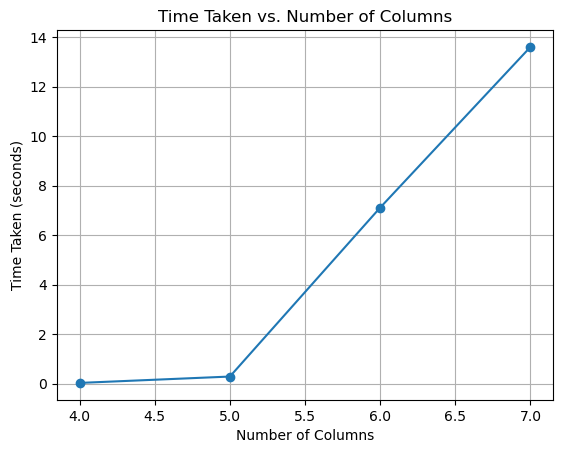

In [53]:
# Plotting
plt.plot(column_sizes, times_taken_deep3, marker='o')
plt.title('Time Taken vs. Number of Columns')
plt.xlabel('Number of Columns')
plt.ylabel('Time Taken (seconds)')
plt.grid(True)
plt.show()

In [54]:
column_sizes = [4, 5, 6, 7]

time_4col6 = measure_time_2(board_4col, deep_6)
time_5col6 = measure_time_2(board_5col, deep_6)
time_6col6 = measure_time_2(board_6col, deep_6)
time_7col6 = measure_time_2(board_7col, deep_6)

times_taken_deep6 = [time_4col6, time_5col6, time_6col6, time_7col6]

Number of nodes searched: 479
Best move for Player 1: Column 2
Number of nodes searched: 3650
Best move for Player 1: Column 2
Number of nodes searched: 68174
Best move for Player 1: Column 2
Number of nodes searched: 101862
Best move for Player 1: Column 2


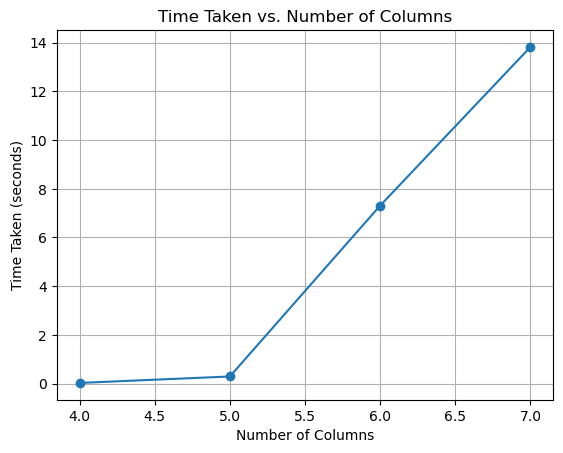

In [55]:
# Plotting
plt.plot(column_sizes, times_taken_deep6, marker='o')
plt.title('Time Taken vs. Number of Columns')
plt.xlabel('Number of Columns')
plt.ylabel('Time Taken (seconds)')
plt.grid(True)
plt.show()

Number of nodes searched: 479
Best move for Player 1: Column 2
Number of nodes searched: 3650
Best move for Player 1: Column 2
Number of nodes searched: 68174
Best move for Player 1: Column 2
Number of nodes searched: 101862
Best move for Player 1: Column 2


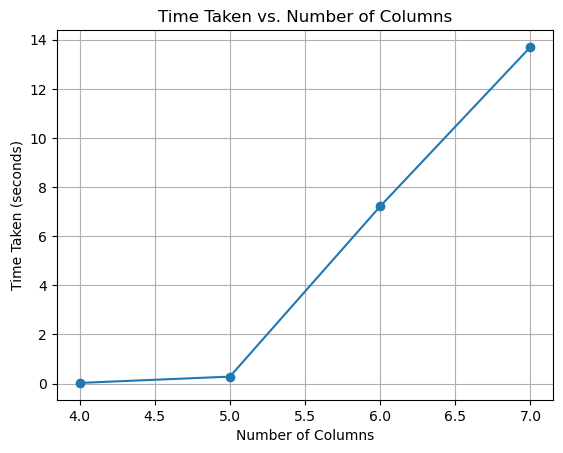

In [56]:
deep_2 = depth_limit(player=1, depth_limit=2)

time_4col2 = measure_time_2(board_4col, deep_2)
time_5col2 = measure_time_2(board_5col, deep_2)
time_6col2 = measure_time_2(board_6col, deep_2)
time_7col2 = measure_time_2(board_7col, deep_2)

times_taken_deep2 = [time_4col2, time_5col2, time_6col2, time_7col2]

# Plotting
plt.plot(column_sizes, times_taken_deep2, marker='o')
plt.title('Time Taken vs. Number of Columns')
plt.xlabel('Number of Columns')
plt.ylabel('Time Taken (seconds)')
plt.grid(True)
plt.show()

Number of nodes searched: 479
Best move for Player 1: Column 2
Number of nodes searched: 3650
Best move for Player 1: Column 2
Number of nodes searched: 68174
Best move for Player 1: Column 2
Number of nodes searched: 101862
Best move for Player 1: Column 2


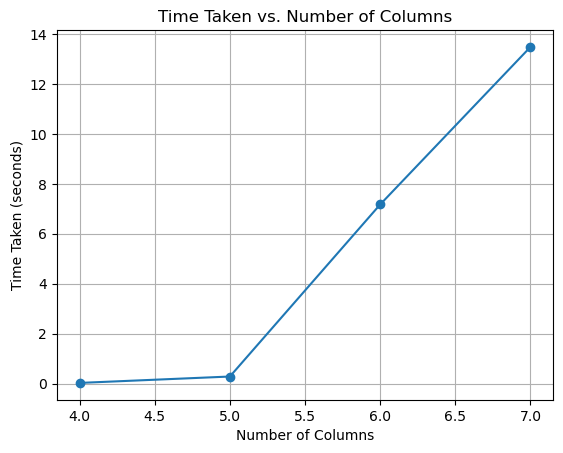

In [57]:
deep_8 = depth_limit(player=1, depth_limit=8)

time_4col8 = measure_time_2(board_4col, deep_8)
time_5col8 = measure_time_2(board_5col, deep_8)
time_6col8 = measure_time_2(board_6col, deep_8)
time_7col8 = measure_time_2(board_7col, deep_8)

times_taken_deep8 = [time_4col8, time_5col8, time_6col8, time_7col8]

# Plotting
plt.plot(column_sizes, times_taken_deep8, marker='o')
plt.title('Time Taken vs. Number of Columns')
plt.xlabel('Number of Columns')
plt.ylabel('Time Taken (seconds)')
plt.grid(True)
plt.show()

#### For my test cases, the time taken follows the number of columns, exponentially increasing as columns increase. Depth doesnt affect the test cases, but will affect them if we use it on empty boards. 

#### This depth limited class definitely performs better than the non hurestic pure min max search as it takes less than half the time. This is because it does not need to play the entire game in order to determine a move

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [67]:
class depth_limit_2:
    def __init__(self, player=1, depth_limit=4, heuristic_func=None):
        self.player = player
        self.COUNT = 0
        self.depth_limit = depth_limit
        self.heuristic_func = heuristic_func if heuristic_func is not None else self.evaluate_board_def
        
    def actions(self, board):
        # Prioritize center columns
        cols = len(board[0])
        center_col = cols // 2
        ordered_actions = [center_col]

        for offset in range(1, center_col + 1):
            left = center_col - offset
            right = center_col + offset
            if left >= 0:
                ordered_actions.append(left)
            if right < cols:
                ordered_actions.append(right)

        return [col for col in ordered_actions if board[0][col] == 0]

    def result(self, board, action, player):
        new_board = np.copy(board)
        for row in reversed(new_board):
            if row[action] == 0:
                row[action] = player
                break
        return new_board

    def terminal(self, board):
        win_for_1 = self.check_winner(board, 1)
        win_for_minus_1 = self.check_winner(board, -1)
        full_board = all(board[0][col] != 0 for col in range(len(board[0])))
        if DEBUG >= 2:
            print(f"Win for 1: {win_for_1}, Win for -1: {win_for_minus_1}, Full board: {full_board}")
        return win_for_1 or win_for_minus_1 or full_board


    def utility(self, board, player):
            if self.check_winner(board, player):
                return float('inf')  # Win
            elif self.check_winner(board, -player):
                return float('-inf')  # Loss
            else:
                return self.evaluate_board_def(board, player)

    def check_winner(self, board, player):
        rows, cols = board.shape

        # Check horizontal locations
        for row in range(rows):
            for col in range(cols - 3):
                if all(board[row][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Horizontal win detected at row {row}, starting at col {col} for player {player}")
                    return True

        # Check vertical locations
        for col in range(cols):
            for row in range(rows - 3):
                if all(board[row + i][col] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Vertical win detected at col {col}, starting at row {row} for player {player}")
                    return True

        # Check negatively sloped diagonals
        for row in range(rows - 3):
            for col in range(cols - 3):
                if all(board[row + i][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Negative diagonal win detected starting at row {row}, col {col} for player {player}")
                    return True

        # Check positively sloped diagonals
        for row in range(3, rows):
            for col in range(cols - 3):
                if all(board[row - i][col + i] == player for i in range(4)):
                    if DEBUG >= 2:
                        print(f"Positive diagonal win detected starting at row {row}, col {col} for player {player}")
                    return True

        return False
    
    def evaluate_board_def(self, board, player):
        score = 0

        # Define scoring criteria
        def score_sequence(sequence, player):
            count_player = np.sum(sequence == player)
            count_empty = np.sum(sequence == 0)

            if count_player == 3 and count_empty == 1:
                return 100  # Three in a row with an open end
            elif count_player == 2 and count_empty == 2:
                return 10  # Two in a row with open ends
            return 0

        rows, cols = board.shape

        # Evaluate all possible sequences
        for row in range(rows):
            for col in range(cols - 3):
                # Horizontal
                horizontal_seq = board[row][col:col + 4]
                score += score_sequence(horizontal_seq, player)

                # Vertical (only if enough rows below)
                if row <= rows - 4:
                    vertical_seq = [board[r][col] for r in range(row, row + 4)]
                    score += score_sequence(vertical_seq, player)

                # Positively sloped diagonals
                if row <= rows - 4:
                    pos_diag_seq = [board[row + i][col + i] for i in range(4)]
                    score += score_sequence(pos_diag_seq, player)

                # Negatively sloped diagonals
                if row >= 3:
                    neg_diag_seq = [board[row - i][col + i] for i in range(4)]
                    score += score_sequence(neg_diag_seq, player)

        # Control of the center column
        center_col = cols // 2
        center_count = sum([1 for r in range(rows) if board[r][center_col] == player])
        score += center_count * 3

        return score

    def minimax_search(self, board, depth=0):
        self.COUNT = 0
        alpha = -math.inf
        beta = math.inf
        value, move = self.max_value(board, alpha, beta, self.player, depth)
        if DEBUG >= 1: 
            print(f"Number of nodes searched: {self.COUNT}")
        return {"move": move, "value": value}

    def max_value(self, state, alpha, beta, player, depth):
        self.COUNT += 1
        if depth == self.depth_limit or self.terminal(state):
            return self.utility(state, player), None

        v, move = -math.inf, None
        for a in self.actions(state):
            v2, _ = self.min_value(self.result(state, a, player), alpha, beta, -player, depth + 1)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if alpha >= beta:
                break  # Beta cutoff
        return v, move

    def min_value(self, state, alpha, beta, player, depth):
        self.COUNT += 1
        if depth == self.depth_limit or self.terminal(state):
            return self.utility(state, -player), None

        v, move = math.inf, None
        for a in self.actions(state):
            v2, _ = self.max_value(self.result(state, a, -player), alpha, beta, player, depth + 1)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if alpha >= beta:
                break  # Alpha cutoff
        return v, move

In [81]:
def evaluate_board_alt(self, board, player):
    score = 0

    # Define scoring criteria
    def score_sequence(sequence, player):
        count_player = np.sum(sequence == player)
        count_opponent = np.sum(sequence == -player)
        count_empty = np.sum(sequence == 0)

        # Check for sequences that are one move away from winning
        if count_player == 3 and count_empty == 1:
            return 1000  # Highly favor sequences where player is one move from winning
        elif count_opponent == 3 and count_empty == 1:
            return 900  # Also highly prioritize blocking opponent's winning move

        # General scoring for other sequences
        if count_player == 2 and count_empty == 2:
            return 10  # Favor sequences with two of player's pieces
        elif count_opponent == 2 and count_empty == 2:
            return 5  # Slightly prioritize blocking opponent's potential wins

        return 0  # Default score for other sequences

    rows, cols = board.shape

    # Evaluate all possible sequences
    for row in range(rows):
        for col in range(cols - 3):
            # Horizontal
            horizontal_seq = board[row][col:col + 4]
            score += score_sequence(horizontal_seq, player)

            # Vertical (only if enough rows below)
            if row <= rows - 4:
                vertical_seq = [board[r][col] for r in range(row, row + 4)]
                score += score_sequence(vertical_seq, player)

            # Positively sloped diagonals
            if row <= rows - 4:
                pos_diag_seq = [board[row + i][col + i] for i in range(4)]
                score += score_sequence(pos_diag_seq, player)

            # Negatively sloped diagonals
            if row >= 3:
                neg_diag_seq = [board[row - i][col + i] for i in range(4)]
                score += score_sequence(neg_diag_seq, player)

    # Consider control of the center column
    center_col = cols // 2
    center_count = sum([1 for r in range(rows) if board[r][center_col] == player])
    score += center_count * 2  # Slightly lower emphasis on center control compared to the first heuristic

    return score


Agent 2 wins!


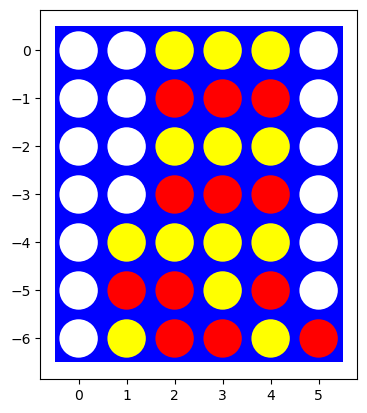

In [103]:
agent1 = depth_limit_2(player=1, depth_limit=5, heuristic_func=None)
agent2 = depth_limit_2(player=-1, depth_limit=3, heuristic_func=evaluate_board_alt)

DEBUG=0
def play_game(agent1, agent2, board):
    current_agent = agent1
    while not agent1.terminal(board):
        action = current_agent.minimax_search(board, depth=0)['move']
        if action is not None:
            board = agent1.result(board, action, current_agent.player)
        current_agent = agent2 if current_agent == agent1 else agent1
    
    final_utility = agent1.utility(board, agent1.player)
    return board, final_utility

board = np.zeros((7, 6), dtype=int)
final_board, final_utility = play_game(agent1, agent2, board)

if final_utility == float('inf'):
    print("Agent 1 wins!")
elif final_utility == float('-inf'):
    print("Agent 2 wins!")
else:
    print("It's a draw!")
visualize(final_board)

### Heuristic with the moves to counter the other player (evaluate_board_alt) proved to perform better and win even though its depth was set to a lower number (3 vs 5) against the default hueristic. 

## Challenge task [+ 10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+10 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [105]:
def random_play(board, player):
    while not terminal(board):
        valid_actions = [col for col in range(len(board[0])) if board[0][col] == 0]
        if not valid_actions:
            break
        action = random.choice(valid_actions)
        board = result(board, action, player)
        player *= -1  # Switch players
    return utility(board)

In [106]:
def pmc_search(board, player, num_simulations=100):
    valid_actions = [col for col in range(len(board[0])) if board[0][col] == 0]
    best_score = float('-inf')
    best_action = None

    for action in valid_actions:
        scores = []
        for _ in range(num_simulations):
            simulated_board = result(np.copy(board), action, player)
            score = random_play(simulated_board, -player)  # Start with opponent's turn
            scores.append(score)

        average_score = sum(scores) / num_simulations
        if average_score > best_score:
            best_score = average_score
            best_action = action

    return best_action


In [110]:
decision1 = pmc_search(board_hor, 1, 100)
print(f"Best move by MC: Column {decision1} should be 6")

decision1 = pmc_search(board_ver, 1, 100)
print(f"Best move by MC: Column {decision1} should be 2")

decision1 = pmc_search(board_pd, 1, 100)
print(f"Best move by MC: Column {decision1} should be 3")

decision1 = pmc_search(board_nd, 1, 100)
print(f"Best move by MC: Column {decision1} should be 2")

decision1 = pmc_search(board_tie, 1, 100)
print(f"Best move by MC: Column {decision1} should be 6")


Best move by MC: Column 6 should be 6
Best move by MC: Column 2 should be 2
Best move by MC: Column 3 should be 3
Best move by MC: Column 2 should be 2
Best move by MC: Column 6 should be 6


#### With iterations of 100, the pure monte carlo algorithm performs well and passes all the tests for vertical, horizontal and diagnal wins. 

### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [111]:
initial_board = np.zeros((6, 7), dtype=int)
decision1 = pure_monte_carlo_search(initial_board, 1, 100)
print(f"Best move by MC: Column {decision1} should be something in the middle")

Best move by MC: Column 2 should be something in the middle


#### 1. Monte Carlo is basically only determining best moves considering the opponent plays randomly. If an opponent is not random and plays with a strategy, monte carlo may not be able to detect that move
#### 2. Number of iterations greatly affect the way monte carlo behaves. I used 100 random iterations, it could perform a lot better with greater iterations, but it could get too computationally expensive.
#### 3. All the games played randomly that feed the monte carlo algorithm are treated with equal probablility, no matter how unlikely that move may be in real world play